In this notebook, I am doing an exploration of the Yelp open data set, located here: https://www.yelp.com/dataset

There will be two parts to the analysis. The first is a form of sentiment analysis, with a focus on regional differences in the positive/negative weighting of individual words. This will be done by using the NLTK pacage to break down review text belonging to different combinations of regions and review scores

The second part utilizes Social Network Analysis (SNA) to draw relationships between businesses in different areas based on common reviewers, and find influential regions, which is expected to coincide with known tourist destinations

In [40]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite as bi

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

import mplleaflet

from collections import OrderedDict 
from operator import getitem 

import math
import collections
from itertools import islice

This is quite a large data set, so after downloading, I am importing it in "chunks" and filtering out columns which will not be relevant to my analysis (although some of them might be useful in a more in-depth analysis.

In [3]:
#getting full list of businesses reviewed
busDF = pd.read_json(r"C:\Users\scohendevries\Documents\DATA620\yelp_dataset\business.json",lines=True)

In [4]:
#large number of reviews, reading in chunks
size = 1000000
review = pd.read_json(r"C:\Users\scohendevries\Documents\DATA620\yelp_dataset\review.json", lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

In [5]:
#then iterating through chunks
chunk_list = []
for chunk_review in review:
    #dropping fields out of scope for this study
    chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    chunk_list.append(chunk_review)
revDF = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [6]:
#inspecting format of reviews table
revDF.head()

,user_id,business_id,review_stars,text,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,I have to say that this office really has it t...,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [7]:
#following same process for Users data
users = pd.read_json(r"C:\Users\scohendevries\Documents\DATA620\yelp_dataset\user.json", lines=True,
                      dtype={'user_id':str,'name':str,
                             'review_count':int,'yelping_since':str,
                             'friends':list,'useful':int,'funny':int,
                             'cool':int,'fans':int,'elite':list,'average_stars':float,
                             'compliment_hot':int,'compliment_more':int,'compliment_profile':int,
                             'compliment_cute':int,'compliment_list':int,'compliment_note':int,
                             'compliment_plain':int,'compliment_cool':int,'compliment_funny':int,
                             'compliment_writer':int,'compliment_photos':int
                            },
                      chunksize=size
                     )

In [8]:
chunk_list = []
for chunk_review in users:
    chunk_review = chunk_review.drop(['yelping_since'
                                      ,'useful'
                                      ,'funny'
                                      ,'cool'
                                      ,'compliment_hot'
                                      ,'compliment_more'
                                      ,'compliment_profile'
                                      ,'compliment_cute'
                                      ,'compliment_list'
                                      ,'compliment_note'
                                      ,'compliment_plain'
                                      ,'compliment_cool'
                                      ,'compliment_funny'
                                      ,'compliment_writer'
                                      ,'compliment_photos'
                                     ], axis=1)
    chunk_list.append(chunk_review)
userDF = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [9]:
userDF.head()

,user_id,name,review_count,elite,friends,fans,average_stars
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,4.03
1,4XChL029mKr5hydo79Ljxg,Jenna,33,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63
2,bc8C_eETBWL0olvFSJJd0w,David,16,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,3.71
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,4.85
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,4.08


The full size of the data set, before filtering, is 190K businesses, 160K users and 6.7MM total reviews.

The first step in processing is to group all the locations into regions, in order to aggregate the data. My first concern is that the data is not evenly distributed between regions (i.e. only 5 distinct businesses in the entire New England region).

The first reduction in size of the review set is to limit it by category. The top categories are:

Restaurants
Shopping                
Food                    
Home Services           
Health & Medical 

I am going to focus my analysis on Restaurants, Shopping, and Health services

In [10]:
#pre-processed numbers from data set
print(str(len(busDF.index)) + ' businesses')
print(str(len(userDF.index)) + ' users')
print(str(len(revDF.index)) + ' reviews')

192609 businesses
1637138 users
6685900 reviews


In [11]:
#Grouping businesses by regions for greater numbers
regionDF = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
busDF = pd.merge(busDF,regionDF,how='inner',left_on='state',right_on='State Code')

In [12]:
busDF.groupby('Division').count()['business_id']

Division
East North Central    21783
East South Central        4
Middle Atlantic       11239
Mountain              93000
New England               5
Pacific                  24
South Atlantic        15890
West North Central        2
West South Central        7
Name: business_id, dtype: int64

In [13]:
#focus on single category
catDF = busDF.assign(categories = busDF.categories
                         .str.split(', ')).explode('categories')
catDF.categories.value_counts()

Restaurants             35878
Shopping                24260
Food                    19177
Home Services           18161
Health & Medical        14898
                        ...  
Sri Lankan                  1
Rotisserie Chicken          1
Hong Kong Style Cafe        1
Calabrian                   1
Dialysis Clinics            1
Name: categories, Length: 1273, dtype: int64

This is still too large a dataset, especially for creating the bipartite projected graph later on. I filter it further to focus on the top 1% of businesses and users, based on the number of reviews they have left/received; for businesses, I am taking the top 1% by region, to ensure I am still getting a diverse set.

The structure of the original data effectively limits the analysis to four regions:
East North Central, Middle Atlantic, Mountain and South Atlantic.

Once the data has been fully filtered down, I join the three sources together to get a master table, including the nodes for my single layer network graph. In total, I am working with just over 100K reviews, still a pretty large set of data, which slows my analysis down, but provides rich feedback.

In [14]:
#further filtering data set by looking at top 5% by number of reviews
#for businesses I group by region to get samples from all regions, rather than skewing numbers towards densely populated areas
#however the original data is mostly centralized in four geographical divisions
busDF = busDF[busDF['categories'].str.contains('Restaurants|Shopping|Health',case=False,na=False)]
busDF['q'] = busDF.groupby(['Division'])['review_count'].rank(pct=True)
busDF = busDF[busDF['q'] > 0.99]
userDF = userDF[userDF.review_count > userDF.review_count.quantile(0.99)]

In [15]:
#in our filtered data set, we still see skewed numbers by state
#this is a function of the data set
print(str(len(busDF.index)) + ' businesses')
print(str(len(userDF.index)) + ' users')

busDF.groupby('Division').count()['business_id']

739 businesses
16365 users


Division
East North Central    127
East South Central      1
Middle Atlantic        65
Mountain              457
New England             1
Pacific                 1
South Atlantic         85
West North Central      1
West South Central      1
Name: business_id, dtype: int64

In [16]:
df = pd.merge(pd.merge(revDF,busDF,how='inner',on='business_id'),userDF,how='inner',on='user_id')

In [17]:
df = df[
    ['user_id'
     ,'business_id'
     ,'city'
     ,'state'
     ,'latitude'
     ,'longitude'
     ,'Region'
     ,'Division'
     ,'name_y'
     ,'review_stars'
     ,'stars'
     ,'average_stars'
     ,'categories'
     ,'text'
     ,'date']
]

In [18]:
#we need to limit the size of our final data set for Network Analysis and Text Processing
print(str(len(df.index)) + ' reviews')

101324 reviews


In [19]:
df = df.rename({'stars':'avgStars_biz'
           ,'average_stars':'avgStars_usr'
          }
         )

In [20]:
df.head(50)

,user_id,business_id,city,state,latitude,longitude,Region,Division,name_y,review_stars,stars,average_stars,categories,text,date
0,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,Las Vegas,NV,36.101449,-115.130511,West,Mountain,Carol,4,4.5,4.16,"Performing Arts, Amusement Parks, Museums, Arc...","Like walking back in time, every Saturday morn...",2011-11-30 02:11:15
1,FIk4lQQu1eTe2EpzQ4xhBA,Wxxvi3LZbHNIDwJ-ZimtnA,Las Vegas,NV,36.121189,-115.169657,West,Mountain,Carol,5,4.0,4.16,"Shopping Centers, Resorts, Arts & Entertainmen...","Love this place, walking into the front desk a...",2011-11-29 17:57:46
2,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",I love a good breakfast! And Bagel Cafe is def...,2010-12-11 13:34:01
3,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",Enjoy a simple breakfast with good service? th...,2014-11-03 18:27:08
4,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",This place is always good. Love the food. If b...,2017-01-10 05:32:10
5,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,4,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...","First time for lunch, it was about 130pm and i...",2012-10-27 04:48:49
6,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...","Always a crowd pleaser. We love the bagels, bu...",2010-10-18 03:55:20
7,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,4,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",Came in to pick up dessert! They have some rea...,2013-05-28 04:40:12
8,FIk4lQQu1eTe2EpzQ4xhBA,JyxHvtj-syke7m9rbza7mA,Las Vegas,NV,36.094457,-115.208867,West,Mountain,Carol,5,3.5,4.16,"Restaurants, Sushi Bars, Japanese","All you can eat sushi, but at a limit of one h...",2011-11-29 17:07:33
9,FIk4lQQu1eTe2EpzQ4xhBA,JyxHvtj-syke7m9rbza7mA,Las Vegas,NV,36.094457,-115.208867,West,Mountain,Carol,4,3.5,4.16,"Restaurants, Sushi Bars, Japanese","This is our second time here, again an AYCE su...",2012-03-22 16:35:12


Now comes the language processing. I am mostly looking at word count by review/region, so will not need some of the more complex NLTK functions (i.e. this analysis does not get into POS tagging, which I would like to include in further research)

To get the most relevant results, I am filtering out stopwords, numbers and punctuation.

Once that is done, I adjust slightly the review score to make it more relevant to positivity/negativity, so that reviews of 1 and 2 are considered negative, 3 is considered neutral, and 4 and 5 are considered positive.

In [21]:
stopWords = set(stopwords.words('english'))

In [22]:
#using nltk to filter out stopwords, numbers and punctuation
def nonStops(text):
    return [word for word in word_tokenize(text) \
            if word.lower() not in stopWords \
            and not word.isdigit()\
            and word.isalpha()
           ]

In [23]:
byReg = {}
allWords = {}
for i in df.itertuples():
    t = nonStops(i.text)
    #leveling weights here, so that a review score of 3 is seen as neutral, and anything above/below is positive/negative
    revWt = i.review_stars - 3
    #creating a dictionary of all words to differentiate weighting by region
    for w in t:
        if w not in allWords.keys():
            allWords[w] = {'n':1,'wt':revWt,'mean':revWt,'stDev':0}
        else:
            allWords[w]['n'] += 1
            allWords[w]['wt'] += revWt
            allWords[w]['mean'] = allWords[w]['wt']/allWords[w]['n']
        if w not in byReg.keys():
            byReg[w] = {}
        if i.Division not in byReg[w].keys():
            byReg[w][i.Division] = {'n':1,'wt':revWt,'mean':revWt}
        else:
            byReg[w][i.Division]['n'] += 1
            byReg[w][i.Division]['wt'] += revWt
            byReg[w][i.Division]['mean'] = byReg[w][i.Division]['wt']/byReg[w][i.Division]['n']

To search for words that might be getting used differently across regions, I look at which are the most "volatile". In other words, which words have the greatest Standard Deviation, where the mean is the average review score containing the word, and the values are the mean review score containing the word *by region*

Ultimately, I focus this analysis on the top 10 most volatile, since they will need to be examined individually.

In [24]:
for i in allWords.keys():
    mn = allWords[i]['wt']/allWords[i]['n']
    sdn = 0
    n = 0
    for j in byReg[i].keys():
        sdn += byReg[i][j]['mean'] - mn
        n += 1
    sd = (sdn**2.0)/(n)
    allWords[i]['stDev'] = sd

In [27]:
#in order to find words which might have their sentiment vary by region, we find those with the most volatility in terms of related review scores
topsd_dict = OrderedDict(sorted(allWords.items(),key = lambda x: getitem(x[1], 'stDev'),reverse=True))
top10 = list(islice(topsd_dict, 100))[:10]

In [28]:
textDF = pd.DataFrame()
for i in top10:
    stgDF = pd.DataFrame(df[df['text'].str.contains(i)][['Division','review_stars','text']])
    stgDF['word'] = i
    textDF = pd.concat([textDF,stgDF])

,Division,review_stars,text,word
2080,Mountain,3,I feel like I came in on an off night. \n\nThi...,Tail
3486,Mountain,4,"""I just want to begin by saying to Roosevelt E...",Tail
3756,Mountain,5,"Return on Investment, Creating Community or wh...",Tail
3785,East North Central,2,Items Selected:\nSausage and Pepperoni Pizza\n...,Tail
3821,Mountain,1,"Being completely honest, I'm usually not a fan...",Tail
...,...,...,...,...
90024,Mountain,3,"As a fan of all things Gordon Ramsey, we decid...",Goodbye
92183,Mountain,1,James Brown is dead. And so is Tao.\n\nWe cam...,Goodbye
94531,Mountain,5,Excellent service by Juice and Keith. Gotta h...,Goodbye
96729,Mountain,4,Something different from the pretentious* upsc...,Goodbye


I struggled with how to present this data, and made some attempts at visualization, but ultimately decided that the best way to consume the data was by looking through the actual text.

So I ultimately output a "report" for each word, showing all reviews containing it, sorted by review score, and tagged with the Region.

In [72]:
#norm = plt.Normalize(1,25)
#cmap = plt.cm.RdYlGn

#fig,ax = plt.subplots()
fig=plt.figure(figsize=(5,2), dpi= 100, facecolor='w', edgecolor='k')
for w in top10:
    with open(w+'.txt','a+') as file:
        for rev in textDF[textDF['text'].str.contains(w)].sort_values(by=['review_stars']).itertuples():
            try:
                file.write(rev.Division + ':' + str(rev.review_stars) + '\n' + rev.text.replace(w,'****'+w.upper()+'****') + '\n\n\n\n')
            except:
                pass
    #plt.scatter(textDF[textDF['word']==w]['Division']
    #            ,textDF[textDF['word']==w]['review_stars']
    #            ,s=100
    #           )
    #plt.title(w)
    #plt.show()

Middle Atlantic:1
Oh where to begin.  I have been to Nola's three times and have had three different types of experiences.  The first time was for lunch in 2012.  From what I can recall it was decent.  The next time I went to Nola was for brunch over my birthday weekend.  The Big Y Group, in case you didn't know, offers birthday dinners/lunch or brunches around your birthday if you sign up online.  You should sign up it's a good deal and you can use it at most of their locations.  So on to Brunch.

We made reservations.  Not needed, I believe we were the only people in there at 11:30 on a sunny Sunday in August.  We had a waitress who was training another girl.  We ordered some beer and OJ to make beermimosas , try it if you haven't.  It's not just for hipsters kids.  I ordered the Eggs Trivette, Toasted Challah Bread, Crawfish ****TAIL**** Meat, Black Pepper Bacon, Crystal Béchamel, Over-Easy Eggs, Served with Fruit Salad.  The wait was a little on the long side being that we were din

<Figure size 500x200 with 0 Axes>

For the network analysis, I created a bipartite graph to create connections between businesses. I utilize the island method to reduce the size of the set for visualization.

In [30]:
#The second part of the analysis involves a network analysis of business, based on patrons
usr = df['user_id'].values.tolist()
biz = df['business_id'].values.tolist()

g=nx.from_pandas_edgelist(df,'user_id','business_id',['city','state','latitude','longitude'])

print(len(g))

13475


In [31]:
#creating a bipartite graph with Businesses as the top node
bNet = bi.weighted_projected_graph(g, biz)

In [32]:
for i in sorted(nx.connected_components(bNet), key = len, reverse=True)[0:20]:
    print(len(i))

736


In [33]:
#Defining a set of functions to utilize the island method for network analysis
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

def sorted_map(d):
    ms = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return ms

Since each node has an associated lat/lon, I can visualize this as a map. Due to system limitations, I was not able to project this ont an actual U.S. map, but you can see below that the majority of the connections run through Nevada and Arizona.

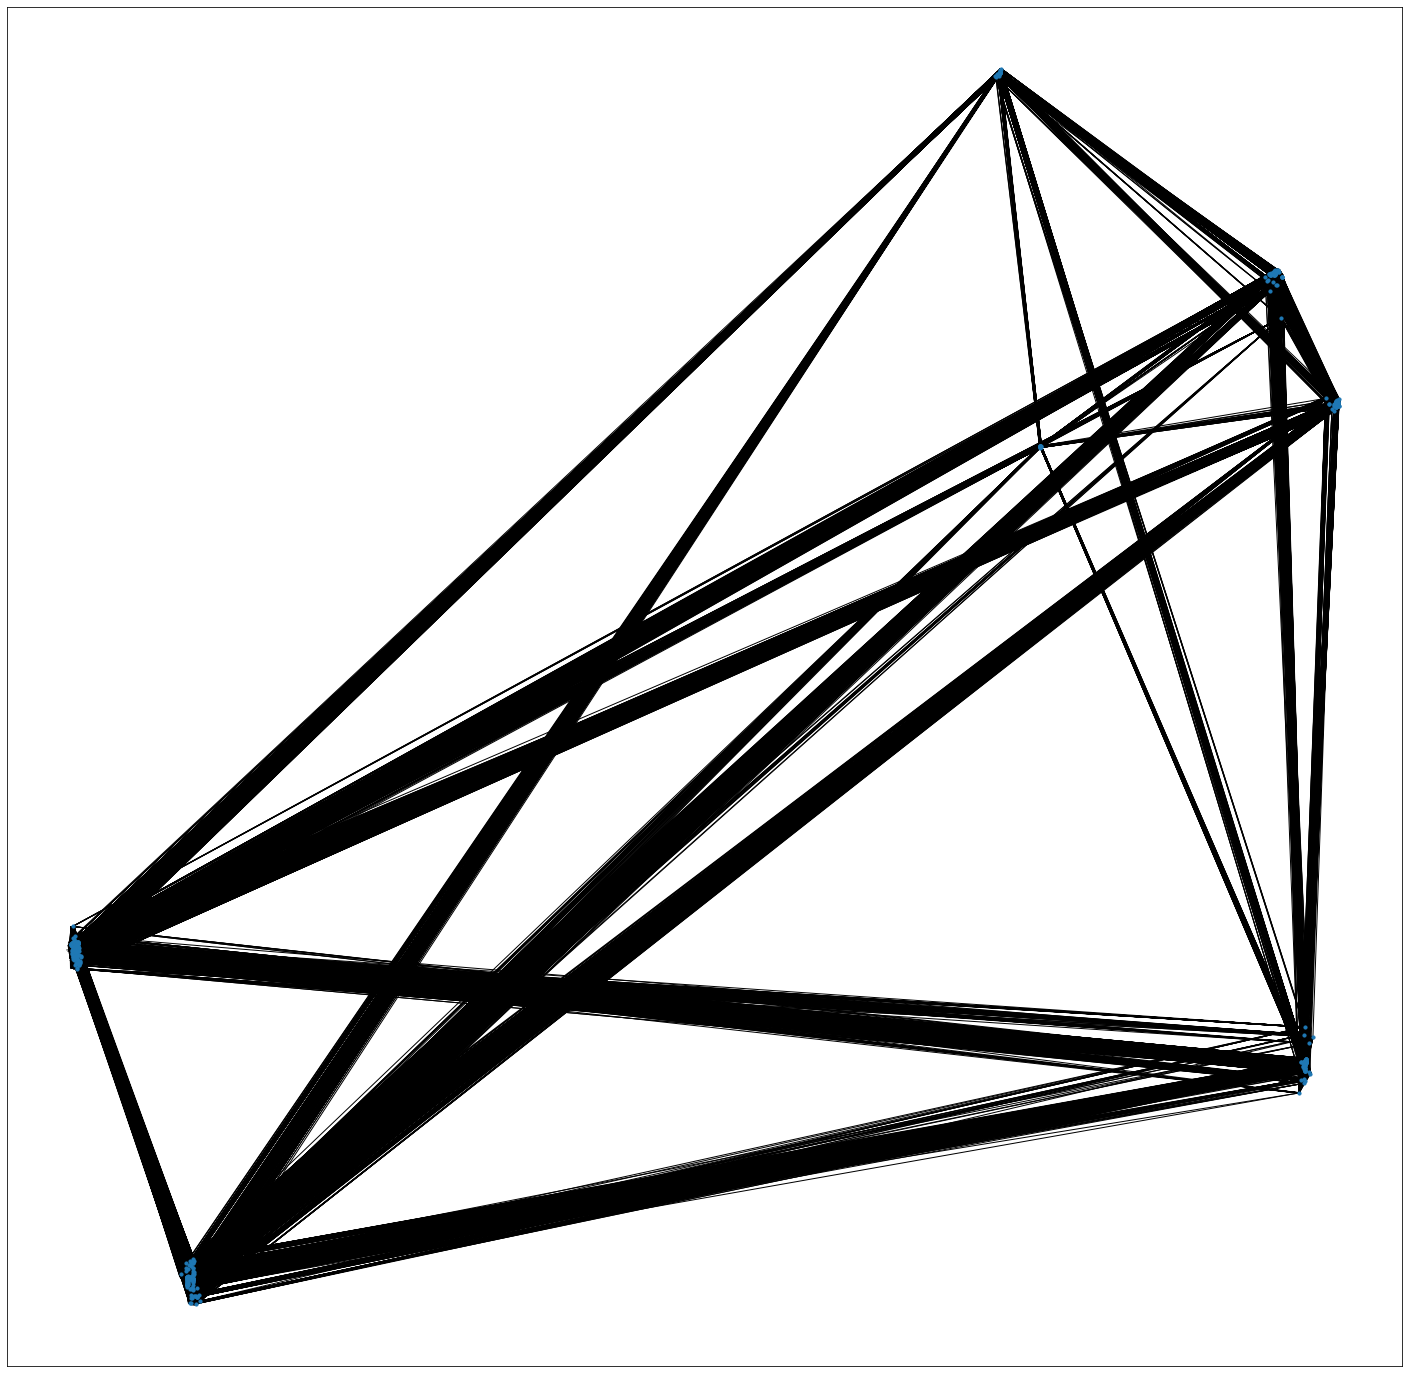

In [75]:
bPos = busDF[['business_id','longitude','latitude']].set_index('business_id')[['longitude','latitude']].T.apply(tuple)
pos = bPos.to_dict()

plt.figure(3,figsize=(25,25)) 
bweights=[math.sqrt(edata['weight']) for f,t,edata in bNet.edges(data=True)]
nx.draw_networkx(bNet
                 , pos
                 , width=bweights
                 , node_size=10
                 , with_labels=False)
plt.show()

(array([9.5436e+04, 3.2948e+04, 7.2060e+03, 1.2080e+03, 3.4600e+02,
        1.3000e+02, 3.6000e+01, 1.6000e+01, 8.0000e+00, 2.0000e+00]),
 array([ 1.        ,  2.89499373,  4.78998747,  6.6849812 ,  8.57997494,
        10.47496867, 12.36996241, 14.26495614, 16.15994987, 18.05494361,
        19.94993734]),
 <a list of 10 Patch objects>)

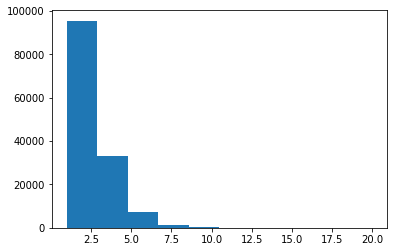

In [35]:
plt.hist(bweights)

In [56]:
bnet_trim=trim_edges(bNet, weight=7.5)

btwn = nx.betweenness_centrality(bnet_trim)
sizes = [btwn[i]*10000 for i in bnet_trim.nodes]
state_dict = busDF[['business_id','state']].set_index('business_id')[['state']].to_dict()#.T.apply(tuple)
labels = [state_dict['state'][biz] for biz in state_dict['state'].keys()]

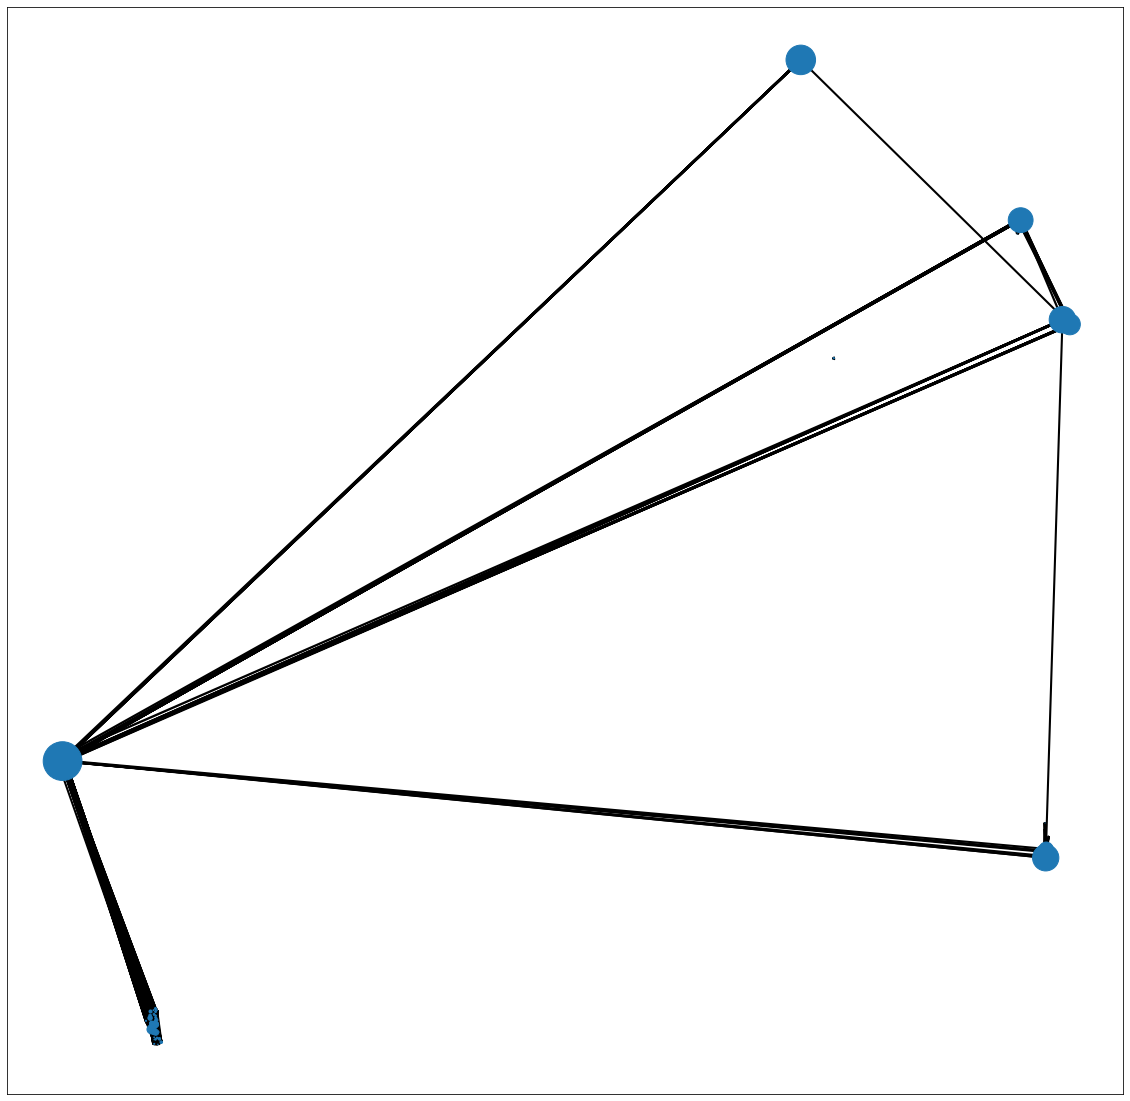

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

weights=[math.log(edata['weight']) for f,t,edata in bnet_trim.edges(data=True)]
nx.draw_networkx(bnet_trim
                 , pos
                 , with_labels=False
                 , node_size=sizes
                 #, labels=state_dict['state']
                 , font_size=24
                 , width=weights
                )
#nx.draw_networkx_labels(bnet_trim,pos,nx.get_node_attributes(g,'city'),font_size=16,font_color='b')
#mplleaflet.display(fig=fig) 

Finally, I take a quick look at the top "influencers". In this context, a high degree of centrality denoted a restaurant that is often reviewed by users who visit multiple other regions. In that regard, it is not surprising to see Las Vegas here, as it is a popular tourist hub. But it is interesting that the highest scores belong to restaurants in Charlotte, NC

In [78]:
#top connected businesses could be interpreted as "tourist" centers, in that they represent places of business which are
#reviews by patrons who review/patronize other businesses (presumably in other areas)
top_biz = []
for i in sorted_map(btwn)[:20]:
    top_biz.append(i[0])
busDF[busDF['business_id'].isin(top_biz)][
    [
        'name'
        ,'city'
        ,'state'
        ,'stars'
        ,'review_count'
    ]
]

,name,city,state,stars,review_count
58848,Tupelo Honey,Charlotte,NC,4.0,1502
59820,The Cowfish Sushi Burger Bar,Charlotte,NC,4.0,1572
65457,Good Food on Montford,Charlotte,NC,4.5,671
69714,Soul Gastrolounge,Charlotte,NC,4.0,934
71789,The Buffet at Bellagio,Las Vegas,NV,3.5,4227
71913,The Venetian Las Vegas,Las Vegas,NV,4.0,3499
77023,Secret Pizza,Las Vegas,NV,4.0,4286
78112,Wicked Spoon,Las Vegas,NV,3.5,6708
81118,Holsteins,Las Vegas,NV,4.0,3159
86961,Mon Ami Gabi,Las Vegas,NV,4.0,8348


References:

Much of the import process was leveraged from:
https://towardsdatascience.com/converting-yelp-dataset-to-csv-using-pandas-2a4c8f03bd88